In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Activation
from keras.utils import np_utils
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from tensorflow.python.ops.numpy_ops.np_math_ops import log
import matplotlib.pyplot as plt
import numpy as np
from functools import wraps
from time import time
import random
print(tf.__version__)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

2.8.0


In [ ]:
def get_data():
  """
  Code copied from the link given in assignment description

  Returns
  -------
  tr_x : 60000,784 numpy array
  tr_y : 60000,10 numpy array
  te_x : 10000,784 numpy array
  te_y : 10000,10 numpy array
  
  """

  # load the training and test data    
  fashion_mnist = tf.keras.datasets.fashion_mnist
  (tr_x, tr_y), (te_x, te_y) = fashion_mnist.load_data()

  # reshape the feature data
  tr_x = tr_x.reshape(tr_x.shape[0], 784)
  te_x = te_x.reshape(te_x.shape[0], 784)

  # noramlise feature data
  tr_x = tr_x / 255.0
  te_x = te_x / 255.0

  print( "Shape of training features ", tr_x.shape)
  print( "Shape of test features ", te_x.shape)

  # one hot encode the training labels and get the transpose
  tr_y = np_utils.to_categorical(tr_y,10)
  # tr_y = tr_y.T
  print ("Shape of training labels ", tr_y.shape)

  # one hot encode the test labels and get the transpose
  te_y = np_utils.to_categorical(te_y,10)
  # te_y = te_y.T
  print ("Shape of testing labels ", te_y.shape)

  return tr_x, tr_y, te_x, te_y

The figure below is from the lecture notes, it is an example if one instance X with n features mutiplied with n weights, all these products are added and passed through an activation layer (layed 1 - ReLu and layer 2 SoftMax to generate output y_predicted)

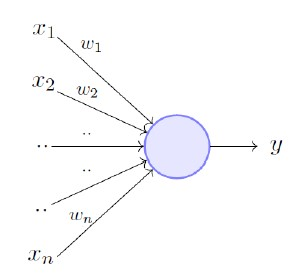

In [ ]:
def forward_pass(X, W1, B1, W2, B2, W3, B3):#, dropoutProb):
  """ 
  Performs forward pass for the neural network
  
  Parameters
  ----------
  X : 60000,784 TensorFlow Variables of training data
  W1 : 300,784 TensorFlow Variables of layer 1 weights 
  B1 : 300,1 TensorFlow Variables of layer 1 bias
  W2 : 100,300 TensorFlow Variables of layer 2 weights 
  B2 : 100,1 TensorFlow Variables of layer 2 bias
  W3 : 10,100 TensorFlow Variables of layer 3 weights 
  B3 : 10,1 TensorFlow Variables of layer 3 bias

  Returns
  -------
  A3 : 60000,10 tensorflow variables of softmax layer output, probabilities of 10 classes of 60000 images
  """


  #Layer1, ReLu activation with 300 neurons
  Z1 = tf.matmul(X,tf.transpose(W1)) + B1
  A1 = Activation('relu')(Z1) #shape 60,000 X 200

  #Dropping 20% of the neurons
  # keepProb = 1 - dropoutProb  #1 - 0.2 = 0.8 (80% neurons ae kept) 
  # dropMatrix = np.random.rand(A1.shape[0], A1.shape[1]) < keepProb  
  # A1 = A1 * dropMatrix #20% neurons are set to 0, or dropped for the next layer
  # A1 = A1 / keepProb #to scale the 80% neuron to 100%

  #Layer2, ReLu activation with 100 neurons
  Z2 = tf.matmul(A1, tf.transpose(W2)) + B2 
  A2 = Activation('relu')(Z2)

  #Layer3, SoftMax layer with 10 neurons (10 classes)
  Z3 = tf.matmul(A2, tf.transpose(W3)) + B3
  A3 = tf.exp(Z3)/tf.reduce_sum(tf.exp(Z3), axis=-1).reshape(Z3.shape[0],1)
  # print(tf.reduce_sum(A2, axis=-1)) # checking if the probabilities add to 1 on all rows

  #Layer3

  return A3


Muticlass Cross Entropy loss L is given by

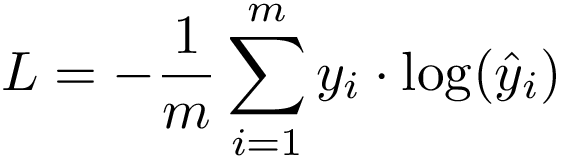


Where, 
yi is the ith instance true class lables,

y_cap_i is the ith predicted class probabilities,

m is the number of images in the dataset


In [ ]:
def cross_entropy(pred_y, true_y):
  """
  Performs Categorical Cross Entropy Loss calculation

  Parameters
  ----------
  pred_y : 60000,10 tensorflow variables from softmax layer - forward_pass()
  true_y : 60000,10 tensorflow variables of input image categorical lables 

  Returns
  -------
  loss : float32 value of Categorical Cross Entropy loss calculated as shown in the figure above
  """
  # cce = tf.keras.losses.CategoricalCrossentropy()
  # print("This is the loss from built in function", cce(true_y, pred_y).numpy())
  loss  = -tf.reduce_mean(tf.reduce_sum(true_y * (tf.math.log(pred_y)), axis=-1))
  return loss


In [ ]:
def calculate_accuracy(pred_y, true_y):
  """
  Calculate accuracy

  Parameters
  ----------
  pred_y : 60000,10 tensorflow variables from softmax layer - forward_pass()
  true_y : 60000,10 tensorflow variables of input image categorical lables 

  Returns
  -------
  acr : float32 value of Accuracy between predicted class and True class
  
    """
  pred_y = tf.round(pred_y)
  pred_correct = tf.cast(tf.equal(pred_y, true_y), tf.float32)
  acr = tf.reduce_mean(pred_correct)
  return acr

In [ ]:
#Copied from Quora answers - https://stackoverflow.com/questions/2245161/how-to-measure-execution-time-of-functions-automatically-in-python
def timed(f):
    wraps(f)
    def wrapper(*args, **kwargs):
        start_time = time()
        res = f(*args, **kwargs)
        elapsed = time() - start_time
        print ("Execution time for function {} is: {} minutes".format(f.__name__, elapsed/60))
        return res
    return wrapper


In [ ]:
@timed
def main():
  # tf.random.set_seed(50)
  num_Iters = 5
  # dropOutProb = 0.1
  minibatch = 64
  adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  train_loss, train_acc, test_loss, test_acc, epoc,  = [], [], [], [], []
  
  #get processed data from get_data()
  train_x, train_y, test_x, test_y = get_data()
  
  # Create tensorflow variables and change datatype to float64
  dt = tf.float32
  train_x = tf.cast(train_x, dt)
  train_y = tf.cast(train_y, dt)
  test_x = tf.cast(test_x, dt)
  test_y = tf.cast(test_y, dt)

  #when using RELU, multiply the weights with sqrt(2/n) to mitigate vanishing/exploding weights for large 'n' - Andrew Ng 
  W1 = tf.Variable(tf.random.normal([300,784]) * tf.sqrt(2/784))
  W2 = tf.Variable(tf.random.normal([100,300]) * tf.sqrt(2/300))
  W3 = tf.Variable(tf.random.normal([10,100]) * tf.sqrt(2/100))
  B1 = tf.Variable(tf.zeros([1]))
  B2 = tf.Variable(tf.zeros([1]))
  B3 = tf.Variable(tf.zeros([1]))

  m = train_x.shape[0]
  mini = m/minibatch

  for i in range(num_Iters):
    epoc.append(i)
    batch_X_axis, batchLoss, batchAcc = [], [], []

    #random shuffle of the dataset before slicing them into batches
    data = list(zip(train_x,train_y))
    random.shuffle(data)
    train_x, train_y = zip(*data)

    for j in range(1,round(mini)):
      batch_X_axis.append(j)
      tr_x = train_x[(j-1)*minibatch : (j)*minibatch] #mini batch of train_x from shuffled data
      tr_y = train_y[(j-1)*minibatch : (j)*minibatch] #mini batch of train_y from shuffled data

      with tf.GradientTape() as tape:
        predicted_y = forward_pass(tr_x, W1, B1, W2, B2, W3, B3) 
        crossEntLoss = cross_entropy(predicted_y, tr_y)
        batchLoss.append(crossEntLoss) 
      gradients = tape.gradient(crossEntLoss,[W1, W2, W3, B1, B2, B3])
      accuracy = calculate_accuracy(predicted_y, tr_y)
      batchAcc.append(accuracy)
      print( "Mini batch: {}, Loss: {}, Accuracy: {}".format(j, crossEntLoss, accuracy))
      adam_optimizer.apply_gradients(zip(gradients,[W1, W2, W3, B1, B2, B3]))

    train_loss.append(crossEntLoss)
    train_acc.append(accuracy)
    print("Epoch: {}, Loss: {}, Accuracy: {}".format(i, crossEntLoss, accuracy))

    #test data - validate
    pred_y = forward_pass(test_x, W1, B1, W2, B2, W3, B3) #, dropOutProb)
    loss = cross_entropy(pred_y, test_y)
    test_loss.append(loss)
    accuracy = calculate_accuracy(pred_y, test_y)
    test_acc.append(accuracy)

    
  # plotting train curves for batch loops- https://stackoverflow.com/questions/67248885/plot-four-curve-with-one-x-axis-and-2-different-y-axis-on-the-same-plot-in-pytho
    fig = plt.figure(figsize=(7,5))
    fig.suptitle("Question SGD 1_3_1")
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()
    ax1.plot(batch_X_axis,batchAcc, label = 'Train Accuracy')
    # ax1.plot(epoc,test_acc, label = 'Test Accuracy')
    ax2.plot(batch_X_axis,batchLoss, color='green', label = 'Train Loss')
    # ax2.plot(epoc,test_loss, color='red', label = 'Test Loss')
    ax1.set_ylabel("Train Accuracy")
    ax2.set_ylabel("Train Loss")
    ax1.set_xlabel("Mini Batch #")
    ax1.legend(loc ='center', bbox_to_anchor=(0.5, 0.63))
    ax2.legend(loc= 'center', bbox_to_anchor=(0.5, 0.5))
    plt.show()

# plotting four curves - https://stackoverflow.com/questions/67248885/plot-four-curve-with-one-x-axis-and-2-different-y-axis-on-the-same-plot-in-pytho
  fig = plt.figure(figsize=(7,5))
  fig.suptitle("Question 1_3_1")
  ax1 = fig.add_subplot()
  ax2 = ax1.twinx()
  ax1.plot(epoc,train_acc, label = 'Train Accuracy')
  ax1.plot(epoc,test_acc, label = 'Test Accuracy')
  ax2.plot(epoc,train_loss, color='green', label = 'Train Loss')
  ax2.plot(epoc,test_loss, color='red', label = 'Test Loss')
  ax1.set_ylabel("Train / Test Accuracy")
  ax2.set_ylabel("Train / Test Loss")
  ax1.set_xlabel("Epoch #")
  ax1.legend(loc ='center', bbox_to_anchor=(0.5, 0.63))
  ax2.legend(loc= 'center', bbox_to_anchor=(0.5, 0.5))
  plt.show()



Shape of training features  (60000, 784)
Shape of test features  (10000, 784)
Shape of training labels  (60000, 10)
Shape of testing labels  (10000, 10)
Mini batch: 1, Loss: 2.744569778442383, Accuracy: 0.8999999761581421
Mini batch: 2, Loss: 2.401939868927002, Accuracy: 0.8999999761581421
Mini batch: 3, Loss: 2.4716994762420654, Accuracy: 0.8999999761581421
Mini batch: 4, Loss: 2.457109212875366, Accuracy: 0.8999999761581421
Mini batch: 5, Loss: 2.4256582260131836, Accuracy: 0.8999999761581421
Mini batch: 6, Loss: 2.3673741817474365, Accuracy: 0.8999999761581421
Mini batch: 7, Loss: 2.30275559425354, Accuracy: 0.8999999761581421
Mini batch: 8, Loss: 2.3466057777404785, Accuracy: 0.8999999761581421
Mini batch: 9, Loss: 2.1936371326446533, Accuracy: 0.8999999761581421
Mini batch: 10, Loss: 2.1064045429229736, Accuracy: 0.8999999761581421
Mini batch: 11, Loss: 2.1086063385009766, Accuracy: 0.8999999761581421
Mini batch: 12, Loss: 2.0959153175354004, Accuracy: 0.8999999761581421
Mini batc

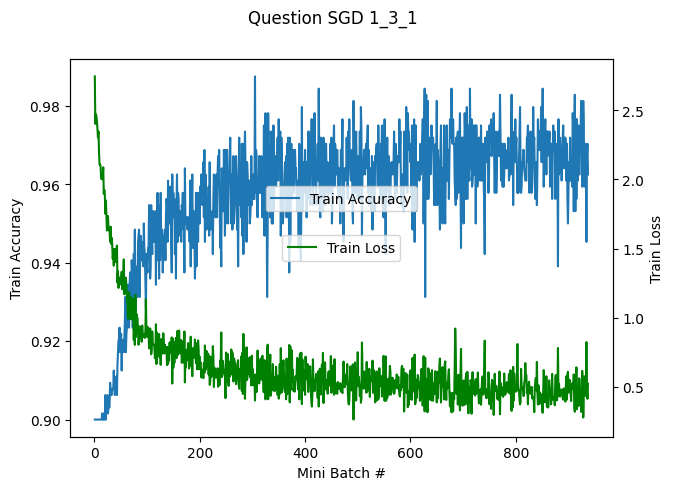

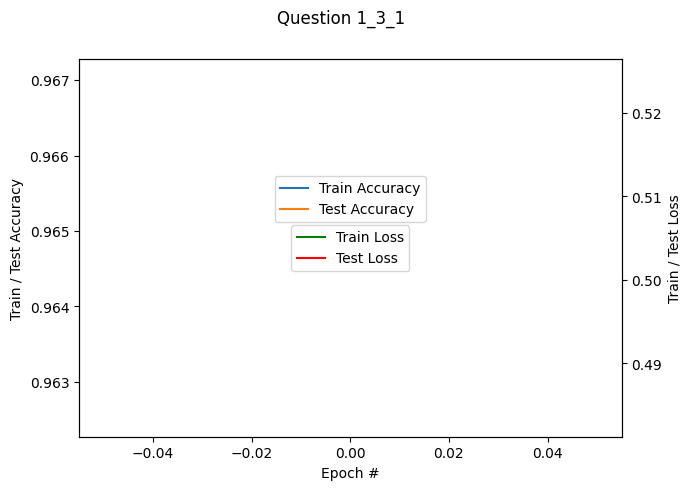

In [ ]:
if __name__ == '__main__':
  main()